# Dog Bite Detection Model Training

This notebook trains a YOLO model for detecting dog bite scenarios with 5 classes:
- chasing dog
- child
- dog
- dog biting child
- running child

Dataset: Roboflow format with train/valid/test splits

## 1. Setup and Imports

In [1]:
!pip install ultralytics
!pip install matplotlib seaborn pandas numpy opencv-python pillow
!pip install wandb  # For experiment tracking (optional)

import os
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from PIL import Image
import random
from collections import Counter

from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
sns.set_palette("husl")

print("✅ All packages imported successfully!")


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\Users\DELL\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\Users\DELL\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\Users\DELL\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


✅ All packages imported successfully!


## 2. Dataset Configuration

In [2]:
# Dataset paths
DATASET_ROOT = Path(r"C:/Users/DELL/Desktop/Area 51/Delhi-Sarkaar/last-hope")
DATA_YAML = DATASET_ROOT / "data.yaml"

# Training configuration
MODEL_SIZE = 'yolov8n'  # Options: yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
IMG_SIZE = 640
BATCH_SIZE = 16
EPOCHS = 100
PATIENCE = 20  # Early stopping patience
WORKERS = 4
DEVICE = '0' if os.system('nvidia-smi') == 0 else 'cpu'

# Class names
CLASS_NAMES = ['chasing dog', 'child', 'dog', 'dog biting child', 'running child']
NUM_CLASSES = len(CLASS_NAMES)

print(f"Dataset root: {DATASET_ROOT}")
print(f"Using device: {DEVICE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")

Dataset root: C:\Users\DELL\Desktop\Area 51\Delhi-Sarkaar\last-hope
Using device: cpu
Number of classes: 5
Classes: ['chasing dog', 'child', 'dog', 'dog biting child', 'running child']


## 3. Dataset Exploration

In [3]:
def explore_dataset(dataset_root):
    """Explore the dataset structure and class distribution"""
    
    # Count files in each split
    splits = ['train', 'valid', 'test']
    dataset_info = {}
    
    for split in splits:
        images_dir = dataset_root / split / 'images'
        labels_dir = dataset_root / split / 'labels'
        
        if images_dir.exists():
            num_images = len(list(images_dir.glob('*.jpg')))
            num_labels = len(list(labels_dir.glob('*.txt'))) if labels_dir.exists() else 0
            
            dataset_info[split] = {
                'images': num_images,
                'labels': num_labels,
                'matched': num_images == num_labels
            }
    
    return dataset_info

def analyze_class_distribution(dataset_root, split='train'):
    """Analyze class distribution in the dataset"""
    labels_dir = dataset_root / split / 'labels'
    class_counts = Counter()
    total_objects = 0
    
    for label_file in labels_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1
                    total_objects += 1
    
    return class_counts, total_objects

# Explore dataset
print("📊 Dataset Structure:")
print("=" * 50)
dataset_info = explore_dataset(DATASET_ROOT)

for split, info in dataset_info.items():
    status = "✅" if info['matched'] else "❌"
    print(f"{split.upper():>6}: {info['images']:>4} images, {info['labels']:>4} labels {status}")

print("\n📈 Class Distribution Analysis:")
print("=" * 50)
class_counts, total_objects = analyze_class_distribution(DATASET_ROOT, 'train')

for class_id in sorted(class_counts.keys()):
    class_name = CLASS_NAMES[class_id]
    count = class_counts[class_id]
    percentage = (count / total_objects) * 100
    print(f"{class_name:>15}: {count:>4} objects ({percentage:>5.1f}%)")

print(f"\n{'Total Objects':>15}: {total_objects:>4}")

📊 Dataset Structure:
 TRAIN:  933 images,  933 labels ✅
 VALID:   82 images,   82 labels ✅
  TEST:   38 images,   38 labels ✅

📈 Class Distribution Analysis:
    chasing dog:  591 objects ( 26.4%)
          child:  513 objects ( 23.0%)
            dog:  687 objects ( 30.7%)
dog biting child:  273 objects ( 12.2%)
  running child:  171 objects (  7.7%)

  Total Objects: 2235


## 4. Data Visualization

<Figure size 1200x800 with 0 Axes>

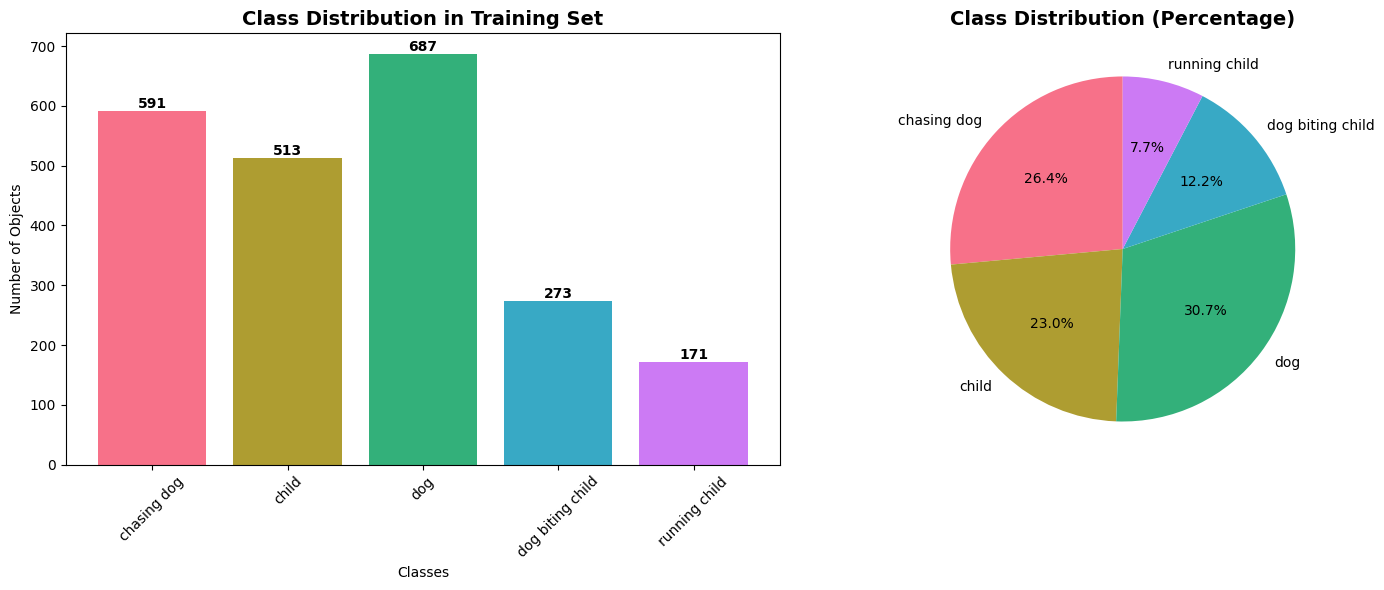

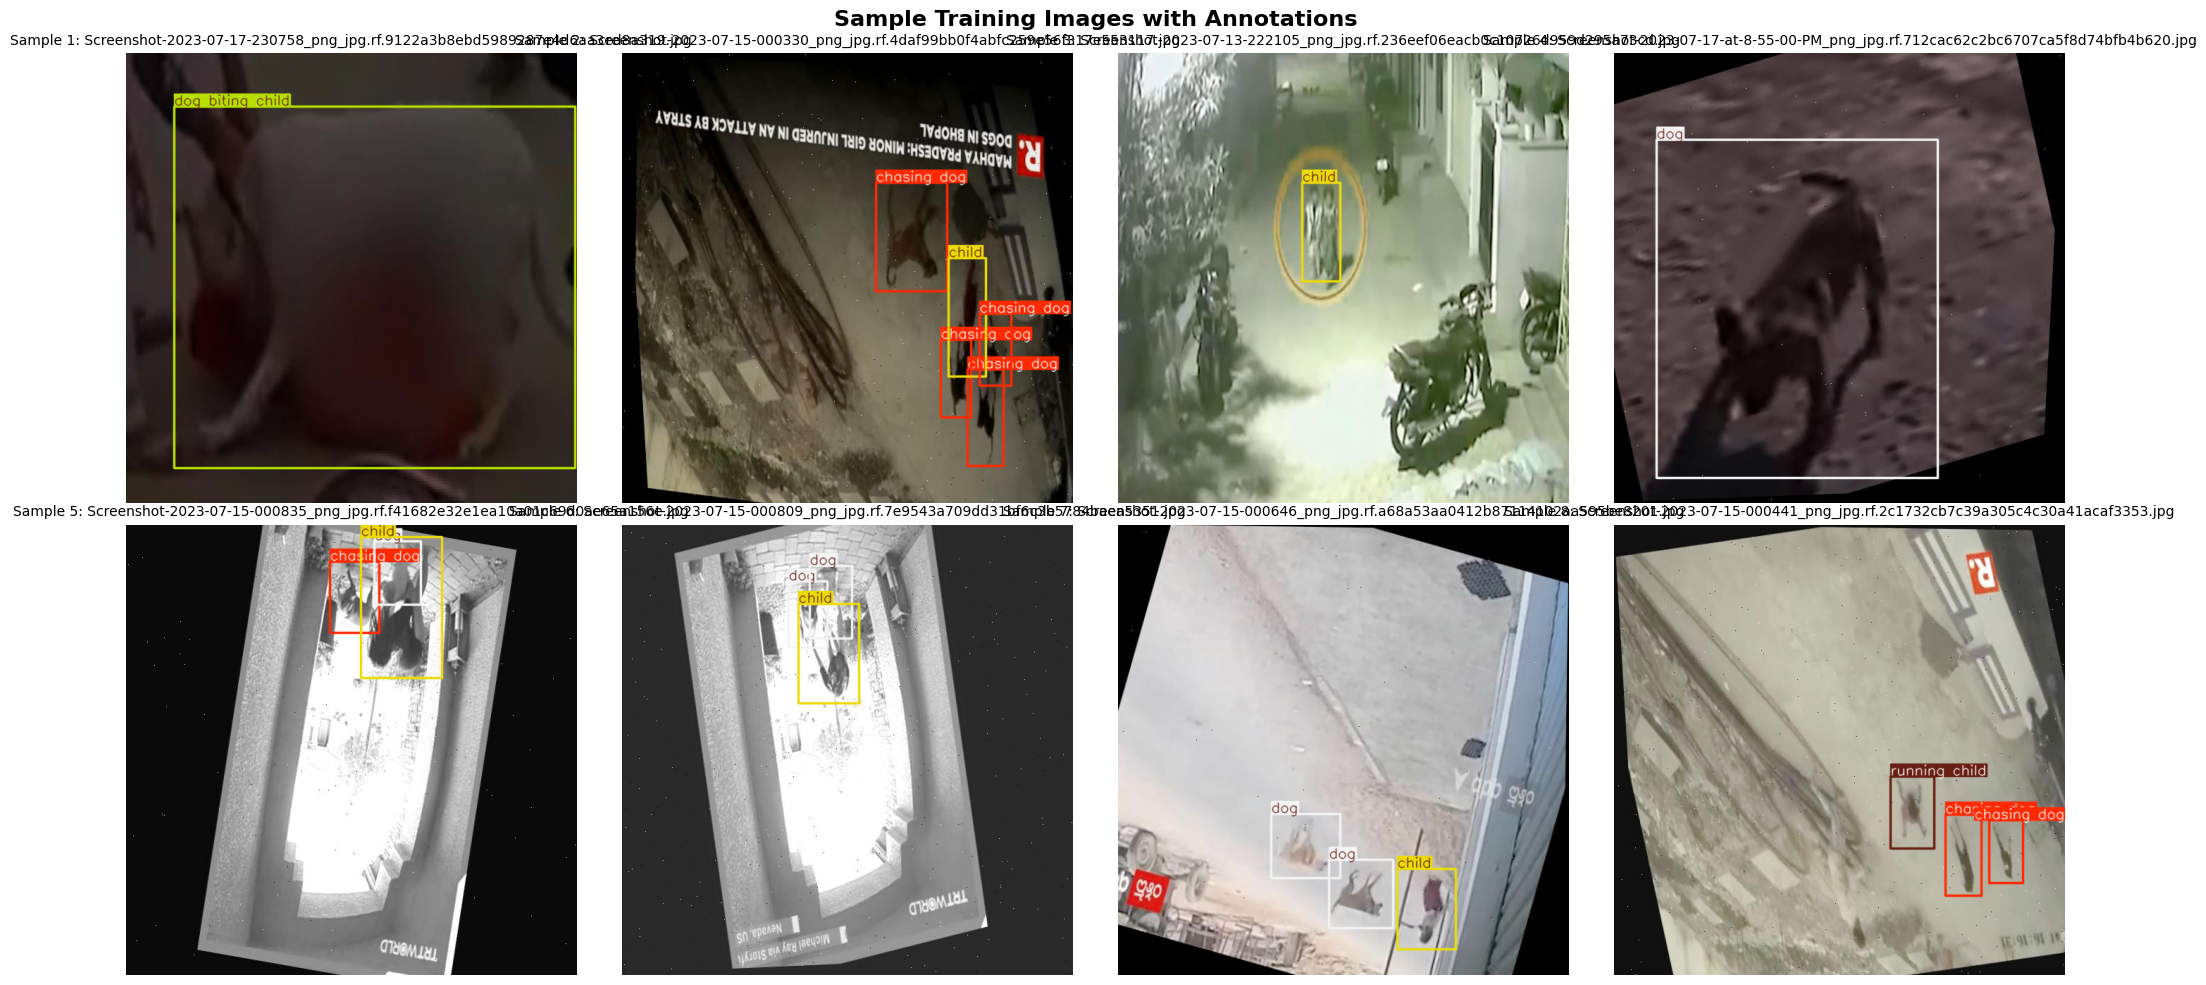

In [4]:
def plot_class_distribution(class_counts, class_names):
    """Plot class distribution"""
    plt.figure(figsize=(12, 8))
    
    # Prepare data
    classes = [class_names[i] for i in sorted(class_counts.keys())]
    counts = [class_counts[i] for i in sorted(class_counts.keys())]
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot
    bars = ax1.bar(classes, counts, color=sns.color_palette("husl", len(classes)))
    ax1.set_title('Class Distribution in Training Set', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Number of Objects')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    ax2.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90,
           colors=sns.color_palette("husl", len(classes)))
    ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def visualize_sample_images(dataset_root, num_samples=8):
    """Visualize sample images with annotations"""
    train_images_dir = dataset_root / 'train' / 'images'
    train_labels_dir = dataset_root / 'train' / 'labels'
    
    # Get random sample of images
    image_files = list(train_images_dir.glob('*.jpg'))
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    # Create subplot
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for idx, img_path in enumerate(sample_files):
        if idx >= num_samples:
            break
            
        # Load image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Load corresponding label
        label_path = train_labels_dir / (img_path.stem + '.txt')
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            # Draw bounding boxes
            annotator = Annotator(img, line_width=2)
            
            for line in lines:
                if line.strip():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:5])
                    
                    # Convert YOLO format to pixel coordinates
                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)
                    
                    # Draw bounding box
                    color = colors(class_id, True)
                    annotator.box_label([x1, y1, x2, y2], 
                                       CLASS_NAMES[class_id], 
                                       color=color)
            
            img = annotator.result()
        
        axes[idx].imshow(img)
        axes[idx].set_title(f'Sample {idx+1}: {img_path.name}', fontsize=10)
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(num_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Sample Training Images with Annotations', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create visualizations
plot_class_distribution(class_counts, CLASS_NAMES)
visualize_sample_images(DATASET_ROOT)

## 5. Model Setup and Training

In [5]:
# Create/verify data.yaml file
data_config = {
    'train': str(DATASET_ROOT / 'train' / 'images'),
    'val': str(DATASET_ROOT / 'valid' / 'images'),
    'test': str(DATASET_ROOT / 'test' / 'images'),
    'nc': NUM_CLASSES,
    'names': CLASS_NAMES
}

# Write data.yaml
with open(DATA_YAML, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False)

print(f"✅ Created data.yaml at: {DATA_YAML}")
print("\nData configuration:")
with open(DATA_YAML, 'r') as f:
    print(f.read())

✅ Created data.yaml at: C:\Users\DELL\Desktop\Area 51\Delhi-Sarkaar\last-hope\data.yaml

Data configuration:
names:
- chasing dog
- child
- dog
- dog biting child
- running child
nc: 5
test: C:\Users\DELL\Desktop\Area 51\Delhi-Sarkaar\last-hope\test\images
train: C:\Users\DELL\Desktop\Area 51\Delhi-Sarkaar\last-hope\train\images
val: C:\Users\DELL\Desktop\Area 51\Delhi-Sarkaar\last-hope\valid\images



In [6]:
# Initialize YOLO model
print(f"🚀 Initializing {MODEL_SIZE} model...")
model = YOLO(f'{MODEL_SIZE}.pt')  # Load pretrained model

# Display model information
print(f"\n📋 Model Summary:")
print(f"Model: {MODEL_SIZE}")
print(f"Parameters: {sum(p.numel() for p in model.model.parameters()):,}")
print(f"Input size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Classes: {NUM_CLASSES}")

🚀 Initializing yolov8n model...

📋 Model Summary:
Model: yolov8n
Parameters: 3,157,200
Input size: 640x640
Classes: 5


In [ ]:
# Training configuration
training_args = {
    'data': str(DATA_YAML),
    'epochs': EPOCHS,
    'imgsz': IMG_SIZE,
    'batch': BATCH_SIZE,
    'device': DEVICE,
    'workers': WORKERS,
    'patience': PATIENCE,
    'save': True,
    'save_period': 10,  # Save checkpoint every 10 epochs
    'project': 'dog_bite_detection',
    'name': f'yolo_{MODEL_SIZE}_training',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'AdamW',
    'lr0': 0.01,
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3,
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'pose': 12.0,
    'kobj': 1.0,
    'label_smoothing': 0.0,
    'nbs': 64,
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 0.0,
    'translate': 0.1,
    'scale': 0.5,
    'shear': 0.0,
    'perspective': 0.0,
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.0,
    'copy_paste': 0.0,
    'auto_augment': 'randaugment',
    'erasing': 0.4,
    'crop_fraction': 1.0,
    'verbose': True
}

print("🏋️ Starting model training...")
print(f"Training configuration: {training_args}")
print("\n" + "="*60)
print("TRAINING STARTED - This may take a while...")
print("="*60)

# Train the model
results = model.train(**training_args)

print("\n" + "="*60)
print("🎉 TRAINING COMPLETED!")
print("="*60)

🏋️ Starting model training...
Training configuration: {'data': 'C:\\Users\\DELL\\Desktop\\Area 51\\Delhi-Sarkaar\\last-hope\\data.yaml', 'epochs': 100, 'imgsz': 640, 'batch': 16, 'device': 'cpu', 'workers': 4, 'patience': 20, 'save': True, 'save_period': 10, 'project': 'dog_bite_detection', 'name': 'yolo_yolov8n_training', 'exist_ok': True, 'pretrained': True, 'optimizer': 'AdamW', 'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'pose': 12.0, 'kobj': 1.0, 'label_smoothing': 0.0, 'nbs': 64, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0, 'auto_augment': 'randaugment', 'erasing': 0.4, 'crop_fraction': 1.0, 'verbose': True}

TRAINING STARTED - This may take a while...
New https://pypi.org/project/ultralytics/8.3.1

## 6. Model Evaluation

In [ ]:
# Validate the trained model
print("📊 Evaluating trained model...")

# Validate on test set
val_results = model.val(data=str(DATA_YAML), 
                       imgsz=IMG_SIZE,
                       batch=BATCH_SIZE,
                       device=DEVICE,
                       plots=True,
                       save_json=True,
                       conf=0.25,
                       iou=0.45)

# Print key metrics
print("\n📈 Validation Results:")
print("=" * 50)
print(f"mAP50: {val_results.box.map50:.4f}")
print(f"mAP50-95: {val_results.box.map:.4f}")
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")
print(f"F1-Score: {2 * (val_results.box.mp * val_results.box.mr) / (val_results.box.mp + val_results.box.mr):.4f}")

# Per-class metrics
print("\n📊 Per-Class Metrics:")
print("=" * 70)
print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'mAP50':<12} {'mAP50-95':<12}")
print("-" * 70)

for i, class_name in enumerate(CLASS_NAMES):
    precision = val_results.box.mp if hasattr(val_results.box, 'p') else 0
    recall = val_results.box.mr if hasattr(val_results.box, 'r') else 0
    map50 = val_results.box.ap50[i] if len(val_results.box.ap50) > i else 0
    map_5095 = val_results.box.ap[i] if len(val_results.box.ap) > i else 0
    
    print(f"{class_name:<20} {precision:<12.4f} {recall:<12.4f} {map50:<12.4f} {map_5095:<12.4f}")

## 7. Results Visualization

In [ ]:
def plot_training_results(results_dir):
    """Plot training results from results.csv"""
    results_csv = results_dir / 'results.csv'
    
    if not results_csv.exists():
        print(f"Results file not found: {results_csv}")
        return
    
    # Load results
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Training and validation loss
    axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linewidth=2)
    axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', linewidth=2)
    axes[0, 0].set_title('Box Loss', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Class loss
    axes[0, 1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', linewidth=2)
    axes[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', linewidth=2)
    axes[0, 1].set_title('Classification Loss', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # DFL loss
    axes[0, 2].plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss', linewidth=2)
    axes[0, 2].plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss', linewidth=2)
    axes[0, 2].set_title('DFL Loss', fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Precision and Recall
    axes[1, 0].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', linewidth=2, color='green')
    axes[1, 0].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', linewidth=2, color='orange')
    axes[1, 0].set_title('Precision & Recall', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # mAP scores
    axes[1, 1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', linewidth=2, color='red')
    axes[1, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', linewidth=2, color='blue')
    axes[1, 1].set_title('mAP Scores', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('mAP')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Learning rate
    lr_cols = [col for col in df.columns if 'lr' in col.lower()]
    if lr_cols:
        axes[1, 2].plot(df['epoch'], df[lr_cols[0]], label='Learning Rate', linewidth=2, color='purple')
        axes[1, 2].set_title('Learning Rate', fontweight='bold')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('LR')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    else:
        axes[1, 2].axis('off')
    
    plt.suptitle('Training Progress', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Find the latest run directory
project_dir = Path('dog_bite_detection')
if project_dir.exists():
    run_dirs = [d for d in project_dir.iterdir() if d.is_dir() and d.name.startswith('yolo_')]
    if run_dirs:
        latest_run = max(run_dirs, key=lambda x: x.stat().st_mtime)
        print(f"📊 Plotting training results from: {latest_run}")
        plot_training_results(latest_run)
    else:
        print("No training results found")
else:
    print("Project directory not found")

In [ ]:
def test_model_predictions(model, test_images_dir, num_samples=6, conf_threshold=0.25):
    """Test model predictions on sample images"""
    test_images = list(Path(test_images_dir).glob('*.jpg'))
    sample_images = random.sample(test_images, min(num_samples, len(test_images)))
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, img_path in enumerate(sample_images):
        if idx >= num_samples:
            break
        
        # Run prediction
        results = model(str(img_path), conf=conf_threshold, verbose=False)
        
        # Get the annotated image
        annotated_img = results[0].plot()
        
        # Convert BGR to RGB for matplotlib
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(annotated_img)
        axes[idx].set_title(f'Test Prediction {idx+1}\n{img_path.name}', fontsize=10)
        axes[idx].axis('off')
        
        # Print detection details
        detections = results[0].boxes
        if detections is not None and len(detections) > 0:
            print(f"\n🔍 Image {idx+1}: {img_path.name}")
            for i, (conf, cls) in enumerate(zip(detections.conf, detections.cls)):
                class_name = CLASS_NAMES[int(cls)]
                print(f"  Detection {i+1}: {class_name} (confidence: {conf:.3f})")
        else:
            print(f"\n🔍 Image {idx+1}: {img_path.name} - No detections")
    
    # Hide unused subplots
    for idx in range(num_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Model Predictions on Test Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Test the model on validation/test images
test_images_dir = DATASET_ROOT / 'valid' / 'images'
if test_images_dir.exists():
    print("🧪 Testing model predictions...")
    test_model_predictions(model, test_images_dir)
else:
    print(f"Test images directory not found: {test_images_dir}")

## 8. Model Export and Optimization

In [ ]:
# Load the best trained model
best_model_path = None
if project_dir.exists():
    run_dirs = [d for d in project_dir.iterdir() if d.is_dir() and d.name.startswith('yolo_')]
    if run_dirs:
        latest_run = max(run_dirs, key=lambda x: x.stat().st_mtime)
        weights_dir = latest_run / 'weights'
        best_model_path = weights_dir / 'best.pt'

if best_model_path and best_model_path.exists():
    print(f"📦 Loading best model from: {best_model_path}")
    best_model = YOLO(str(best_model_path))
    
    # Export to different formats
    print("\n🚀 Exporting model to different formats...")
    
    export_formats = {
        'onnx': 'ONNX (for deployment)',
        'engine': 'TensorRT (for NVIDIA GPUs)',
        'coreml': 'CoreML (for Apple devices)',
        'openvino': 'OpenVINO (for Intel devices)'
    }
    
    exported_models = {}
    
    for format_name, description in export_formats.items():
        try:
            print(f"\nExporting to {format_name.upper()} - {description}...")
            
            if format_name == 'engine' and DEVICE == 'cpu':
                print("Skipping TensorRT export (requires CUDA GPU)")
                continue
                
            exported_path = best_model.export(format=format_name, imgsz=IMG_SIZE)
            exported_models[format_name] = exported_path
            print(f"✅ Successfully exported to: {exported_path}")
            
        except Exception as e:
            print(f"❌ Failed to export to {format_name}: {str(e)}")
    
    # Show export summary
    print("\n" + "="*60)
    print("📊 EXPORT SUMMARY")
    print("="*60)
    print(f"Original model: {best_model_path}")
    for format_name, path in exported_models.items():
        print(f"{format_name.upper():>10}: {path}")
        
else:
    print("❌ Best model not found. Please check if training completed successfully.")

## 9. Real-time Inference Function

In [ ]:
def detect_dog_bite_scenario(image_path, model, conf_threshold=0.25, iou_threshold=0.45):
    """
    Detect dog bite scenarios in an image
    
    Args:
        image_path: Path to input image
        model: Trained YOLO model
        conf_threshold: Confidence threshold for detections
        iou_threshold: IoU threshold for NMS
    
    Returns:
        dict: Detection results with risk assessment
    """
    
    # Run inference
    results = model(image_path, conf=conf_threshold, iou=iou_threshold, verbose=False)
    
    # Parse detections
    detections = []
    risk_factors = {
        'dog_biting_child': 0,
        'chasing_dog': 0,
        'running_child': 0,
        'dogs_near_children': 0
    }
    
    if results[0].boxes is not None:
        boxes = results[0].boxes
        for i, (box, conf, cls) in enumerate(zip(boxes.xyxy, boxes.conf, boxes.cls)):
            class_id = int(cls)
            class_name = CLASS_NAMES[class_id]
            confidence = float(conf)
            
            detection = {
                'class_id': class_id,
                'class_name': class_name,
                'confidence': confidence,
                'bbox': box.tolist()
            }
            detections.append(detection)
            
            # Update risk factors
            if class_name == 'dog biting child':
                risk_factors['dog_biting_child'] += confidence
            elif class_name == 'chasing dog':
                risk_factors['chasing_dog'] += confidence
            elif class_name == 'running child':
                risk_factors['running_child'] += confidence
    
    # Calculate overall risk score
    high_risk_score = risk_factors['dog_biting_child'] * 1.0
    medium_risk_score = (risk_factors['chasing_dog'] + risk_factors['running_child']) * 0.7
    
    overall_risk = min(high_risk_score + medium_risk_score, 1.0)
    
    # Determine risk level
    if overall_risk >= 0.7:
        risk_level = "HIGH"
        risk_color = "🔴"
    elif overall_risk >= 0.4:
        risk_level = "MEDIUM"
        risk_color = "🟡"
    else:
        risk_level = "LOW"
        risk_color = "🟢"
    
    return {
        'detections': detections,
        'risk_score': overall_risk,
        'risk_level': risk_level,
        'risk_color': risk_color,
        'risk_factors': risk_factors,
        'annotated_image': results[0].plot()
    }

def analyze_image_safety(image_path, model):
    """
    Comprehensive safety analysis of an image
    """
    print(f"🔍 Analyzing image: {Path(image_path).name}")
    print("=" * 50)
    
    # Get detection results
    results = detect_dog_bite_scenario(image_path, model)
    
    # Display risk assessment
    print(f"Risk Level: {results['risk_color']} {results['risk_level']}")
    print(f"Risk Score: {results['risk_score']:.3f}")
    
    # Display detections
    if results['detections']:
        print(f"\n📋 Detections ({len(results['detections'])})")
        for i, det in enumerate(results['detections'], 1):
            print(f"  {i}. {det['class_name']} (confidence: {det['confidence']:.3f})")
    else:
        print("\n📋 No objects detected")
    
    # Display risk factors
    active_risks = [k for k, v in results['risk_factors'].items() if v > 0]
    if active_risks:
        print(f"\n⚠️ Risk Factors:")
        for risk in active_risks:
            score = results['risk_factors'][risk]
            print(f"  • {risk.replace('_', ' ').title()}: {score:.3f}")
    
    # Show annotated image
    annotated_img = cv2.cvtColor(results['annotated_image'], cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_img)
    plt.title(f"Safety Analysis: {results['risk_color']} {results['risk_level']} RISK\nRisk Score: {results['risk_score']:.3f}")
    plt.axis('off')
    plt.show()
    
    return results

# Test the inference function
if best_model_path and best_model_path.exists():
    test_img_dir = DATASET_ROOT / 'valid' / 'images'
    if test_img_dir.exists():
        test_images = list(test_img_dir.glob('*.jpg'))
        if test_images:
            sample_image = random.choice(test_images)
            print("🧪 Testing inference function...\n")
            analyze_image_safety(str(sample_image), best_model)
else:
    print("Model not available for inference testing")

## 10. Training Summary and Recommendations

In [ ]:
# Generate training summary
print("🎯 TRAINING SUMMARY")
print("=" * 60)

# Model information
print(f"📋 Model Configuration:")
print(f"  • Architecture: {MODEL_SIZE.upper()}")
print(f"  • Input Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  • Batch Size: {BATCH_SIZE}")
print(f"  • Epochs: {EPOCHS}")
print(f"  • Device: {DEVICE}")

# Dataset information
print(f"\n📊 Dataset Information:")
print(f"  • Classes: {NUM_CLASSES}")
print(f"  • Class Names: {', '.join(CLASS_NAMES)}")
total_images = sum(info['images'] for info in dataset_info.values())
print(f"  • Total Images: {total_images}")
for split, info in dataset_info.items():
    print(f"  • {split.title()} Set: {info['images']} images")

# Performance metrics (if available)
if 'val_results' in locals():
    print(f"\n🏆 Model Performance:")
    print(f"  • mAP@0.5: {val_results.box.map50:.4f}")
    print(f"  • mAP@0.5:0.95: {val_results.box.map:.4f}")
    print(f"  • Precision: {val_results.box.mp:.4f}")
    print(f"  • Recall: {val_results.box.mr:.4f}")

# Recommendations
print(f"\n💡 Recommendations for Improvement:")
print(f"  1. 📈 Data Augmentation: Increase dataset size with more diverse scenarios")
print(f"  2. ⚖️ Class Balancing: Balance the dataset if some classes are underrepresented")
print(f"  3. 🎯 Hyperparameter Tuning: Experiment with learning rates, batch sizes")
print(f"  4. 🔄 Model Size: Try larger models (YOLOv8m/l/x) for better accuracy")
print(f"  5. 📊 Error Analysis: Analyze misclassified cases for targeted improvements")
print(f"  6. 🏗️ Ensemble Methods: Combine multiple models for robust predictions")

# File locations
if best_model_path and best_model_path.exists():
    print(f"\n📁 Important Files:")
    print(f"  • Best Model: {best_model_path}")
    print(f"  • Dataset Config: {DATA_YAML}")
    print(f"  • Results Directory: {latest_run}")

print(f"\n🎉 Training completed successfully!")
print(f"   The model is ready for deployment and can detect dog bite scenarios.")
print("=" * 60)

## 11. Deployment Code Template

In [ ]:
# Generate deployment code template
deployment_code = '''
# Dog Bite Detection Deployment Template
# Save this as 'dog_bite_detector.py' for production use

import cv2
import numpy as np
from ultralytics import YOLO
from pathlib import Path

class DogBiteDetector:
    def __init__(self, model_path, conf_threshold=0.25):
        """Initialize the dog bite detector"""
        self.model = YOLO(model_path)
        self.conf_threshold = conf_threshold
        self.class_names = ['chasing dog', 'child', 'dog', 'dog biting child', 'running child']
    
    def detect(self, image_source):
        """Detect dog bite scenarios in image/video"""
        results = self.model(image_source, conf=self.conf_threshold, verbose=False)
        return self.process_results(results[0])
    
    def process_results(self, result):
        """Process YOLO results and assess risk"""
        detections = []
        risk_score = 0.0
        
        if result.boxes is not None:
            for box, conf, cls in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls):
                class_id = int(cls)
                class_name = self.class_names[class_id]
                confidence = float(conf)
                
                detections.append({
                    'class': class_name,
                    'confidence': confidence,
                    'bbox': box.tolist()
                })
                
                # Calculate risk score
                if class_name == 'dog biting child':
                    risk_score = max(risk_score, confidence)
                elif class_name in ['chasing dog', 'running child']:
                    risk_score = max(risk_score, confidence * 0.7)
        
        return {
            'detections': detections,
            'risk_score': risk_score,
            'risk_level': 'HIGH' if risk_score > 0.7 else 'MEDIUM' if risk_score > 0.4 else 'LOW',
            'annotated_image': result.plot()
        }

# Example usage:
# detector = DogBiteDetector('path/to/best.pt')
# results = detector.detect('path/to/image.jpg')
# print(f"Risk Level: {results['risk_level']}")
'''

# Save deployment template
with open('dog_bite_detector_template.py', 'w') as f:
    f.write(deployment_code)

print("💻 Deployment template created: 'dog_bite_detector_template.py'")
print("\nYou can use this template to integrate the model into your applications!")